# Importing libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from datetime import datetime
import os
print("Libraries loaded successfully!")

Libraries loaded successfully!


# Setting styles for plots

In [44]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
# Changed to dark grey background for visual impact
plt.rcParams['axes.facecolor'] = '#36454F' # Charcoal grey for plot area
plt.rcParams['figure.facecolor'] = '#2C3539' # Slightly darker grey for figure background
plt.rcParams['grid.color'] = '#555555' # Lighter grid lines for contrast against dark background
plt.rcParams['text.color'] = '#E0E0E0' # Lighter text for contrast
plt.rcParams['xtick.color'] = '#E0E0E0'
plt.rcParams['ytick.color'] = '#E0E0E0'
plt.rcParams['axes.labelcolor'] = '#E0E0E0'
plt.rcParams['axes.titlecolor'] = '#E0E0E0'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Inter', 'Arial', 'Helvetica', 'sans-serif'] # Using Inter font

# 1. Loading Data

In [45]:
print("\n--- Starting Data Loading ---")

file_path = 'new.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Dataset 'new.csv' loaded successfully.")
    print(f"Initial dataset shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
else:
    print(f"Error: '{file_path}' not found. Please ensure the file is in the correct directory.")
    exit()


--- Starting Data Loading ---
Dataset 'new.csv' loaded successfully.
Initial dataset shape: (2240, 29)

First 5 rows of the dataset:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94     

# Data Preprocessing

In [46]:
print("\n--- Starting Data Preprocessing ---")

# Drop irrelevant columns
df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], errors='ignore')
print("Dropped 'ID', 'Z_CostContact', 'Z_Revenue' columns.")

# Handle missing 'Income' values with the median
df['Income'].fillna(df['Income'].median(), inplace=True)
print(f"Missing 'Income' values handled. Median income used: {df['Income'].median():.2f}")

# Convert 'Dt_Customer' to 'Days_Since_Enrollment'
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
# Calculate days since the latest customer enrollment date for consistency
latest_date = df['Dt_Customer'].max()
df['Days_Since_Enrollment'] = (latest_date - df['Dt_Customer']).dt.days
df.drop(columns=['Dt_Customer'], inplace=True)
print("Converted 'Dt_Customer' to 'Days_Since_Enrollment'.")

# Convert 'Year_Birth' to 'Age'
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
# Remove outliers in 'Age' (e.g., ages > 100 or < 18)
df = df[(df['Age'] < 100) & (df['Age'] >= 18)]
df.drop(columns=['Year_Birth'], inplace=True)
print(f"Converted 'Year_Birth' to 'Age'. Removed age outliers. Current dataset shape: {df.shape}")

# Create 'Children' feature
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)
print("Created 'Children' feature and dropped 'Kidhome', 'Teenhome'.")

# Identify numerical and categorical features for scaling and encoding
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'Response' from numerical features for initial scaling, as it's the target
if 'Response' in numerical_features:
    numerical_features.remove('Response')
categorical_features = df.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features for scaling: {numerical_features}")
print(f"Categorical features for encoding: {categorical_features}")

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like 'Response')
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(df.drop(columns=['Response']))
# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Convert processed data back to DataFrame for easier handling
X_df = pd.DataFrame(X_processed, columns=all_feature_names, index=df.index)
y = df['Response'] # Keep the target variable separate

print("\n--- Data Preprocessing Complete ---")
print(f"Processed data shape (features only): {X_df.shape}")
print(f"Target variable shape: {y.shape}")


--- Starting Data Preprocessing ---
Dropped 'ID', 'Z_CostContact', 'Z_Revenue' columns.
Missing 'Income' values handled. Median income used: 51381.50
Converted 'Dt_Customer' to 'Days_Since_Enrollment'.
Converted 'Year_Birth' to 'Age'. Removed age outliers. Current dataset shape: (2237, 29)
Created 'Children' feature and dropped 'Kidhome', 'Teenhome'.

Numerical features for scaling: ['ID', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Days_Since_Enrollment', 'Age', 'Children']
Categorical features for encoding: ['Education', 'Marital_Status']

--- Data Preprocessing Complete ---
Processed data shape (features only): (2237, 38)
Target variable shape: (2237,)


C:\Users\barni\AppData\Local\Temp\ipykernel_24984\2086246839.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


--- Starting Data Preprocessing ---

Dropped 'ID', 'Z_CostContact', 'Z_Revenue' columns.
Missing 'Income' values handled. Median income used: 51381.50
Converted 'Dt_Customer' to 'Days_Since_Enrollment'.
Converted 'Year_Birth' to 'Age'. Removed age outliers. Current dataset shape: (2237, 29)
Created 'Children' feature and dropped 'Kidhome', 'Teenhome'.

Numerical features for scaling: ['ID', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Days_Since_Enrollment', 'Age', 'Children']
Categorical features for encoding: ['Education', 'Marital_Status']

--- Data Preprocessing Complete --- 
Processed data shape (features only): (2237, 38).
Target variable shape: (2237,)

# 3. Microproject 1: Customer Segmentation using Unsupervised ML (K-Means) 


--- Starting Customer Segmentation (K-Means) ---


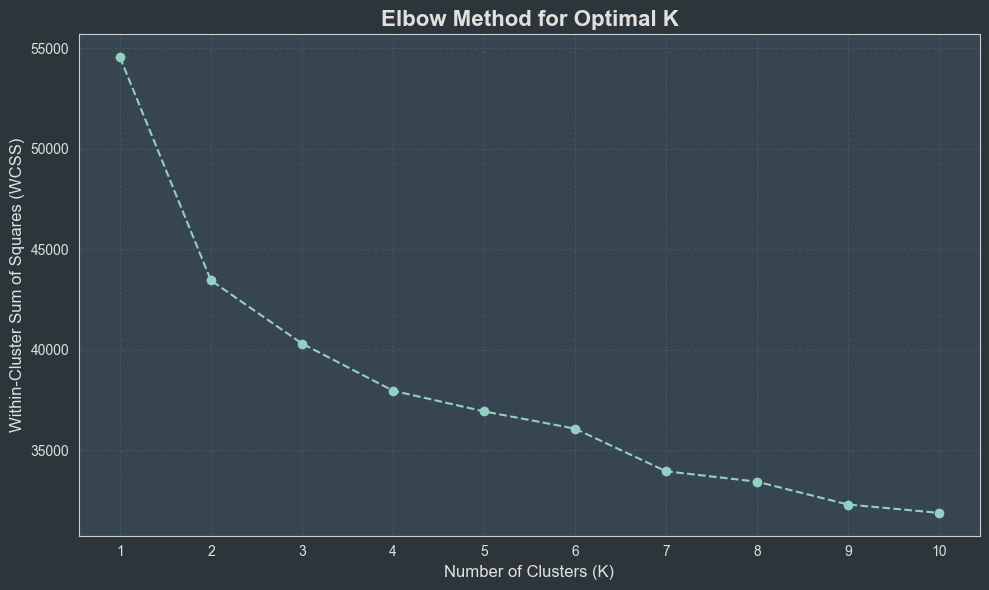



Elbow Method plot displayed. Look for the 'elbow' point to choose the optimal K.


ValueError: operands could not be broadcast together with shapes (10,) (9,) 

In [47]:
print("\n--- Starting Customer Segmentation (K-Means) ---")

# Determine optimal number of clusters using the Elbow Method
wcss = []
max_k = 10
for i in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--', color='#92D1C1')
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(range(1, max_k + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\n")
print("Elbow Method plot displayed. Look for the 'elbow' point to choose the optimal K.")

wcss_diff = np.diff(wcss, prepend=wcss[0])
wcss_change = np.abs(wcss_diff / wcss[:-1])
optimal_k_index = np.argmax(wcss_change[1:]) + 1
optimal_k = range(1, max_k + 1)[optimal_k_index]
print(f"A common heuristic suggests that the optimal number of clusters is {optimal_k}, based on the elbow point.")

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
X_df['Cluster'] = kmeans.fit_predict(X_df)
print(f"K-Means clustering applied with K = {optimal_k}.")
print(f"Cluster distribution:\n{X_df['Cluster'].value_counts()}")



# 4. Microproject 2: Customer Churn Rate Prediction using XGBoost 

In [ ]:

print("\n--- Starting Customer Churn Rate Prediction (XGBoost) ---")

X_churn = X_df.copy()
y_churn = y

X_train, X_test, y_train, y_test = train_test_split(X_churn, y_churn, test_size=0.25, random_state=42, stratify=y_churn)
print(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
print("XGBoost Classifier trained successfully.")

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))

from matplotlib.colors import LinearSegmentedColormap

colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
custom_cmap = LinearSegmentedColormap.from_list("my_palette", colors)




--- Starting Customer Churn Rate Prediction (XGBoost) ---
Data split into training (1677 samples) and testing (560 samples).


c:\Users\barni\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:30:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier trained successfully.

--- Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       476
           1       0.69      0.48      0.56        84

    accuracy                           0.89       560
   macro avg       0.80      0.72      0.75       560
weighted avg       0.88      0.89      0.88       560



# Confusion Matrix

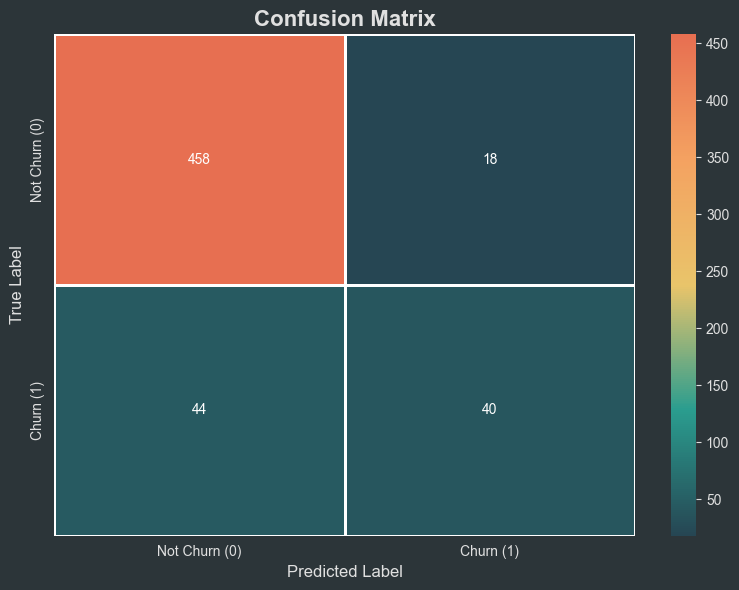

Confusion Matrix displayed.


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=True,
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'],
            linecolor='white', linewidth=2)  # Increased linewidth for clear separation
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()
print("Confusion Matrix displayed.")

# Receiver Operating Characteristic (ROC) Curve (False Positive Rate Vs True Positive Rate)

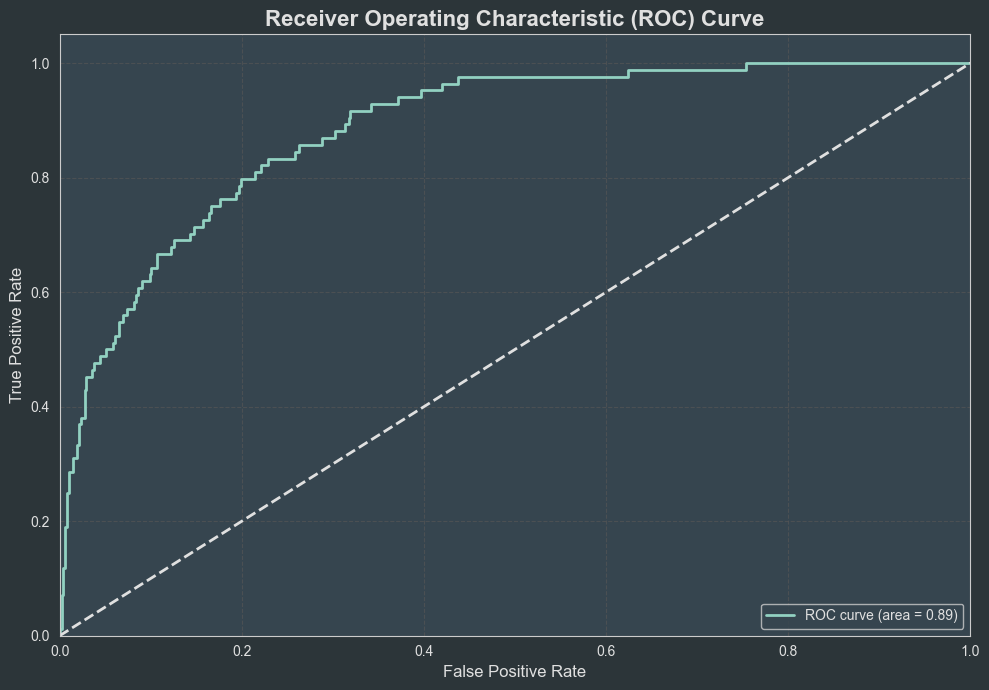



ROC Curve displayed.


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='#92D1C1', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#E0E0E0', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\n")
print("ROC Curve displayed.")

# Top 15 Feature Importances for Churn Prediction in form of bar chart.

C:\Users\barni\AppData\Local\Temp\ipykernel_24984\2899453601.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(15), palette='viridis')


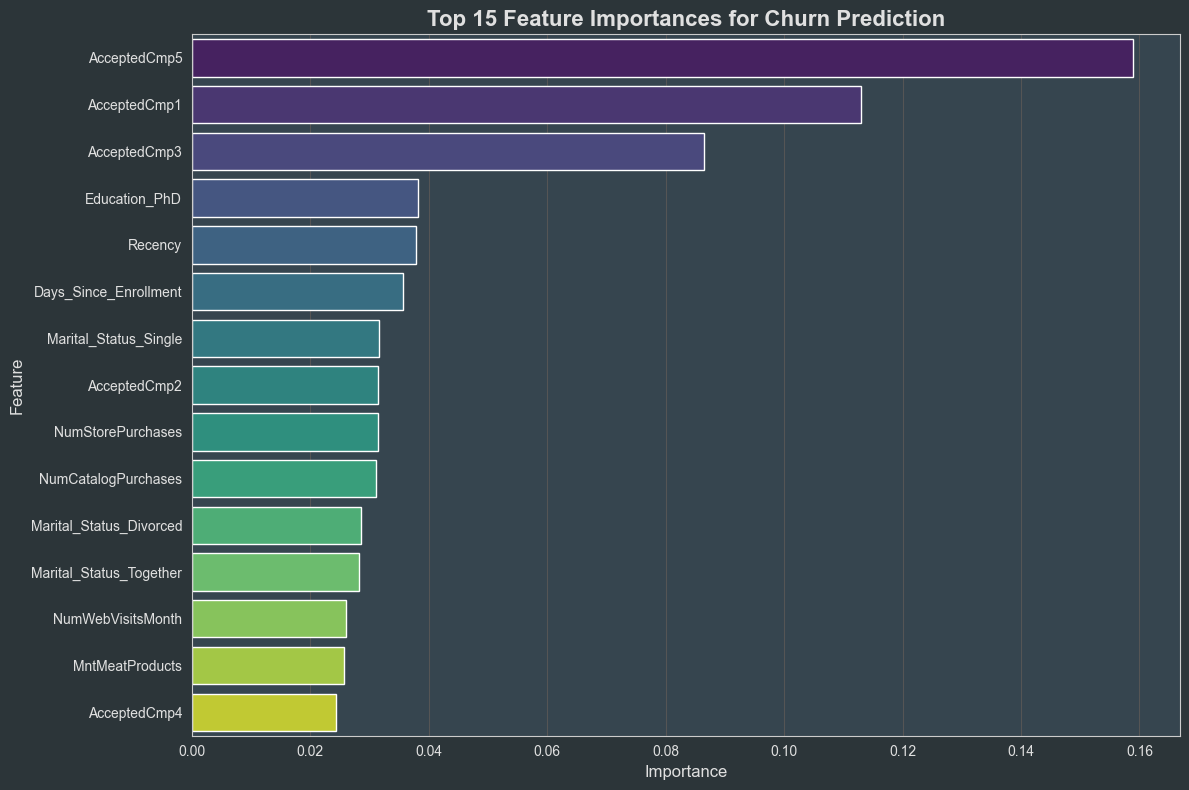

Feature Importance plot displayed.


In [ ]:
feature_importances = pd.DataFrame({
    'feature': X_churn.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances for Churn Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
print("Feature Importance plot displayed.")

# 5. Combined Analysis: Churn Rate by Segment

Created Cluster column with K-means clustering

Actual Churn Rate by Cluster:
   Cluster  Churn_Rate  Customer_Count
0        0    0.142023            1028
1        1    0.182648             219
2        2    0.151052             523
3        3    0.148707             464


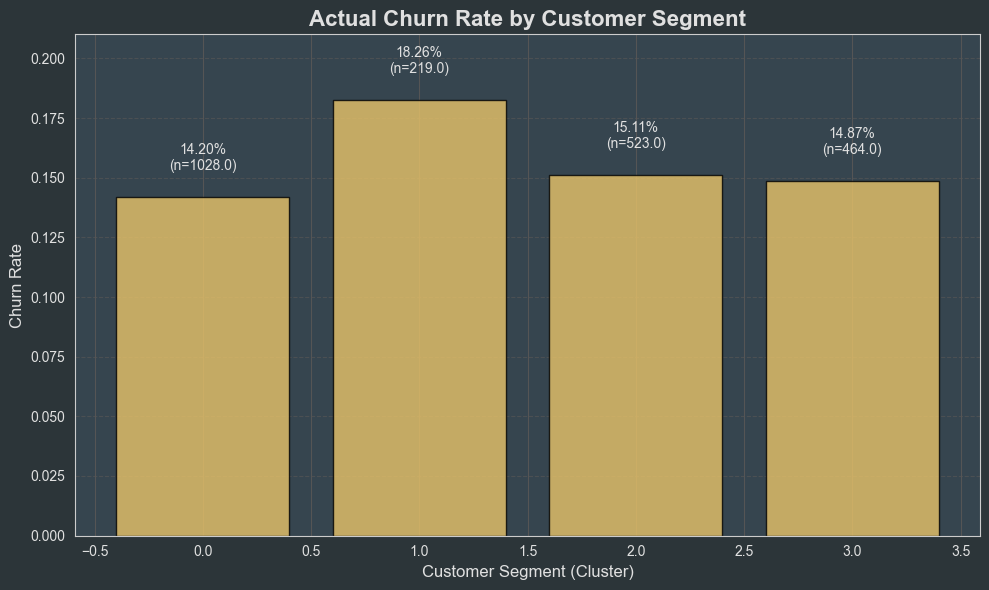


Bar chart showing churn rate by customer segment displayed.

--- Combined Analysis Complete ---

This script provides a comprehensive framework for customer segmentation and churn prediction.


In [61]:
df_clustered = df.copy()
df_clustered['Predicted_Churn'] = xgb_model.predict(X_churn)
df_clustered['Actual_Churn'] = y.copy().reset_index(drop=True)
cluster_column = 'Cluster'  

# If you don't have a cluster column yet, create one:
if cluster_column not in df_clustered.columns:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=4, random_state=42)
    df_clustered[cluster_column] = kmeans.fit_predict(X_churn)
    print(f"Created {cluster_column} column with K-means clustering")

# Calculate churn rate by cluster
churn_rate_by_cluster = df_clustered.groupby(cluster_column)['Actual_Churn'].agg(['mean', 'count']).reset_index()
churn_rate_by_cluster.columns = ['Cluster', 'Churn_Rate', 'Customer_Count']

print("\nActual Churn Rate by Cluster:")
print(churn_rate_by_cluster)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(churn_rate_by_cluster['Cluster'], churn_rate_by_cluster['Churn_Rate'],
                color='#e9c46a', edgecolor='black', alpha=0.8)

plt.title('Actual Churn Rate by Customer Segment', fontsize=16, fontweight='bold')
plt.xlabel('Customer Segment (Cluster)', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, # Adjusted the vertical position
              f'{height:.2%}\n(n={churn_rate_by_cluster.iloc[i]["Customer_Count"]})',
              ha='center', va='bottom', fontsize=10)

# Increase the y-axis limit to create more space for labels
plt.ylim(0, max(churn_rate_by_cluster['Churn_Rate']) * 1.15) # Adjusted y-axis limit to 115% of max value

plt.tight_layout()
plt.show()

print("\nBar chart showing churn rate by customer segment displayed.")

print("\n--- Combined Analysis Complete ---")
print("\nThis script provides a comprehensive framework for customer segmentation and churn prediction.")
